# Task 3 [3p]

Suppose that we have two languages: Upper and Lower. This is an example Upper sentence:

<pre>
THE QUICK BROWN FOX JUMPS OVER THE LAZY DOG.
</pre>

And this is its translation into Lower:

<pre>
the quick brown fox jumps over the lazy dog
</pre>

You have two corpora for these languages (with different sentences); see files [polish_lower](https://drive.google.com/file/d/1H1WMHpf3UXe2Q_QrhuvbxPTbsinvHIHr/view?usp=drive_link), [polish_upper](https://drive.google.com/file/d/1H5117jA6VKiGEizqu15ap6eWkDdbE02t/view?usp=drive_link) . Your task is to train word embedings for both languages together, so as to make embeddings of the words which are its translations as close as possible. But unfortunately, you have the budget which allows you to prepare the translation only for 1000 words (we call it D, you have to deside which words you want to be in D)

Prepare the corpora wich contains three kind of sentences:
* Upper corpus sentences
* Lower corpus sentences
* sentences derived from Upper/Lower corpus, modified using D

There are many possible ways of doing this, for instance this one (ROT13.COM: hfr rirel fragrapr sebz obgu pbecben gjvpr: jvgubhg nal zbqvsvpngvbaf, naq jvgu rirel jbeqf sebz Q ercynprq ol vgf genafyngvba)

We define the score for an Upper WORD as  $\frac{1}{p}$, where $p$ is a position of its translation in the list of **Lower** words most similar to WORD. For instance, when most similar words to DOG are:

<pre>
WOLF, CAT, WOLVES, LION, gopher, dog
</pre>

then the score for the word DOG is 0.5. Compute the average score separately for words from D, and for words out of D (hint: if the computation takes to much time do it for a random sample).

Present embedding using the PCA method or t-SNE. You can use sklearn or any other library for this.


In [82]:
import numpy as np
import random
import gensim
from gensim.models import Word2Vec
from collections import Counter
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity


In [83]:
def load_corpus(path):
    with open(path, 'r', encoding='utf-8') as f:
        return [line.strip().split() for line in f]

upper_sentences = load_corpus('input/task3_polish_upper.txt')
lower_sentences = load_corpus('input/task3_polish_lower.txt')

In [97]:
upper_counts = Counter(word for sent in upper_sentences for word in sent if word.isalpha())
top_upper = [word for word, _ in upper_counts.most_common(1000)]
D = {word: word.lower() for word in top_upper}
reverse_D = {v: k for k, v in D.items()}

In [98]:
print(f"Extracted {len(D)} {len(reverse_D)}")
print("Sample pairs:", list(D.items())[:10])
print("Sample reverse pairs:", list(reverse_D.items())[:10])

Extracted 1000 1000
Sample pairs: [('W', 'w'), ('TEN', 'ten'), ('I', 'i'), ('BYĆ', 'być'), ('NA', 'na'), ('Z', 'z'), ('DO', 'do'), ('SIĘ', 'się'), ('ON', 'on'), ('O', 'o')]
Sample reverse pairs: [('w', 'W'), ('ten', 'TEN'), ('i', 'I'), ('być', 'BYĆ'), ('na', 'NA'), ('z', 'Z'), ('do', 'DO'), ('się', 'SIĘ'), ('on', 'ON'), ('o', 'O')]


In [99]:
modified_upper = [[D.get(word, word) for word in sent] for sent in upper_sentences]
modified_lower = [[reverse_D.get(word, word) for word in sent] for sent in lower_sentences]

combined_corpus = upper_sentences + lower_sentences + modified_upper + modified_lower

In [100]:
print(f"Total sentences in mixed corpus: {len(combined_corpus)}")
print(f"Sample mixed sentences: {combined_corpus[:5]}")

Total sentences in mixed corpus: 2000000
Sample mixed sentences: [['TUTAJ', 'MÓC', 'ZOBACZYĆ', ',', 'JAK', 'WYGLĄDAĆ', 'TEN', 'W', 'PRAKTYKA', ',', 'NA', 'MAPA', 'BYĆ', 'WYSZCZEGÓLNIONY', 'MIEJSCE', 'OBJĘTY', 'PROGRAM', '.'], ['POZWOLIĆ', 'WIĘC', 'SOBIE', 'OSZCZĘDZIĆ', 'TROCHĘ', 'CZAS', 'I', 'PIENIĄDZ', 'DZIĘKI', 'WYKONANIE', 'LUSTRACJA', '.'], ['JEŚLI', 'INTERESOWAĆ', 'ON', 'TAKI', 'USŁUGA', 'JAK', 'SZKOLENIE', 'KIEROWCA', 'POJAZD', 'UPRZYWILEJOWANY', ',', 'TEN', 'WARTA_WARTO', 'TAKŻE', 'WZIĄĆ', 'POD', 'UWAGA', 'TEN', ',', 'Z', 'JAKI', 'KOSZT', 'I', 'OFERTA', 'MAMA_MIEĆ', 'DO', 'CZYNIENIE', ',', 'A', 'NA', 'PEWNO', 'BYĆ', 'MÓC', 'CIESZYĆ', 'SIĘ', 'NAJLEPSZY', 'EFEKT', ',', 'A', 'TEN', 'BYĆ', 'PRZECIEŻ', 'NAJWAŻNIEJSZY', '.'], ['ROMAN', 'ANDRZEJEWSKI', 'DOWÓDCA', '7', 'KOMPANIA', 'STRZELECKI', '-', 'POR.', 'JAN', 'I', 'WOJCIECHOWSKI', '(', 'OD', '4', 'IX', ')', 'DOWÓDCA', '8', 'KOMPANIA', 'STRZELECKI', '-', 'PPOR.'], ['MINISTERSTWO', 'NIE_ON', 'ZMNIEJSZYĆ', 'PER', 'SALDO', 'FINANSOWANI

In [102]:
model = Word2Vec(combined_corpus, vector_size=100, window=5, min_count=1, workers=6)
wv = model.wv


In [103]:
# evaluate translation quality
def compute_score(model, D, all_words, sample_size=1000):
    in_d_scores, out_d_scores = [], []

    for word in tqdm(random.sample(all_words, sample_size)):
        if word.upper() not in model.wv or word.lower() not in model.wv:
            continue
        try:
            similar = [w for w, _ in model.wv.most_similar(word.upper(), topn=100)]
            
            if word.lower() in similar:
                rank = similar.index(word.lower()) + 1
                score = 1.0 / rank
            else:
                score = 0.0

            if word.upper() in D:
                in_d_scores.append(score)
            else:
                out_d_scores.append(score)
        except KeyError:
            continue

    return in_d_scores, out_d_scores

all_unique_words = list(set(w.lower() for s in lower_sentences for w in s))
in_d_scores, out_d_scores = compute_score(model, D, all_unique_words)


100%|██████████| 1000/1000 [00:01<00:00, 633.31it/s]


In [104]:
print(f"Average score for in-D words: {np.mean(in_d_scores):.4f}")
print(f"Average score for out-of-D words: {np.mean(out_d_scores):.4f}")


Average score for in-D words: 0.9844
Average score for out-of-D words: 0.1462


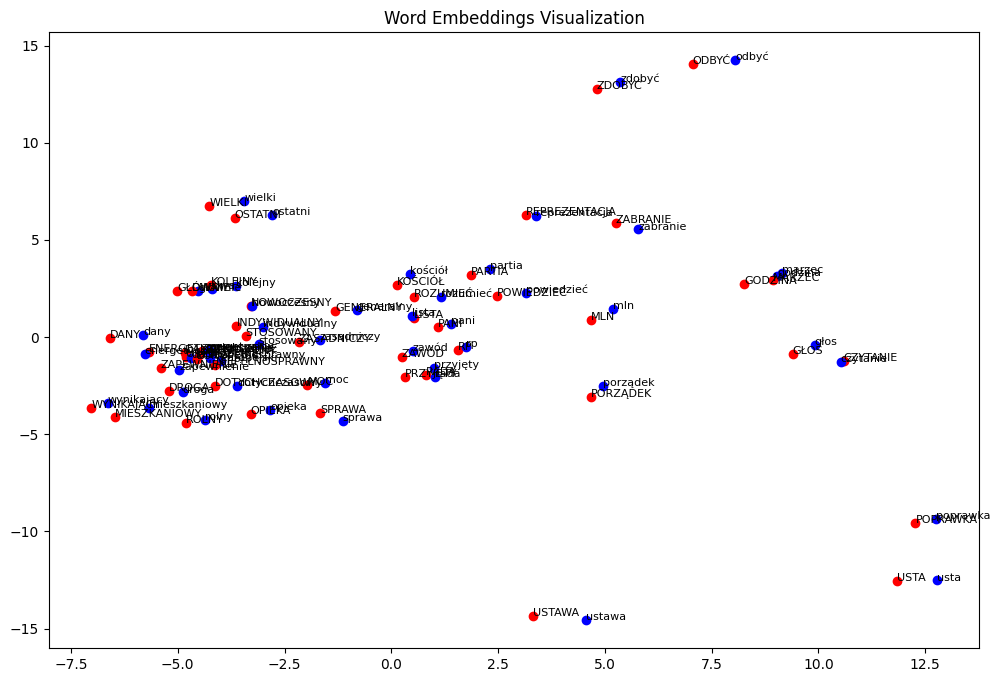

In [113]:
d_words = list(D.keys())
def plot_embeddings(words, translations, wv):
    vectors = []
    labels = []
    for w, t in zip(words, translations):
        if w in wv and t in wv:
            vectors.extend([wv[w], wv[t]])
            labels.extend([w, t])
    
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(vectors)
    
    plt.figure(figsize=(12, 8))
    for i, label in enumerate(labels):
        x, y = reduced[i]
        color = 'red' if label.isupper() else 'blue'
        plt.scatter(x, y, c=color)
        plt.text(x, y, label, fontsize=8)
    
    plt.title('Word Embeddings Visualization')
    plt.show()

sample_words = random.sample(d_words, 50)
sample_trans = [D[w] for w in sample_words]
plot_embeddings(sample_words, sample_trans, wv)

## Sandbox

Average score for D words: 0.9349
Average score for non-D words: 0.3514


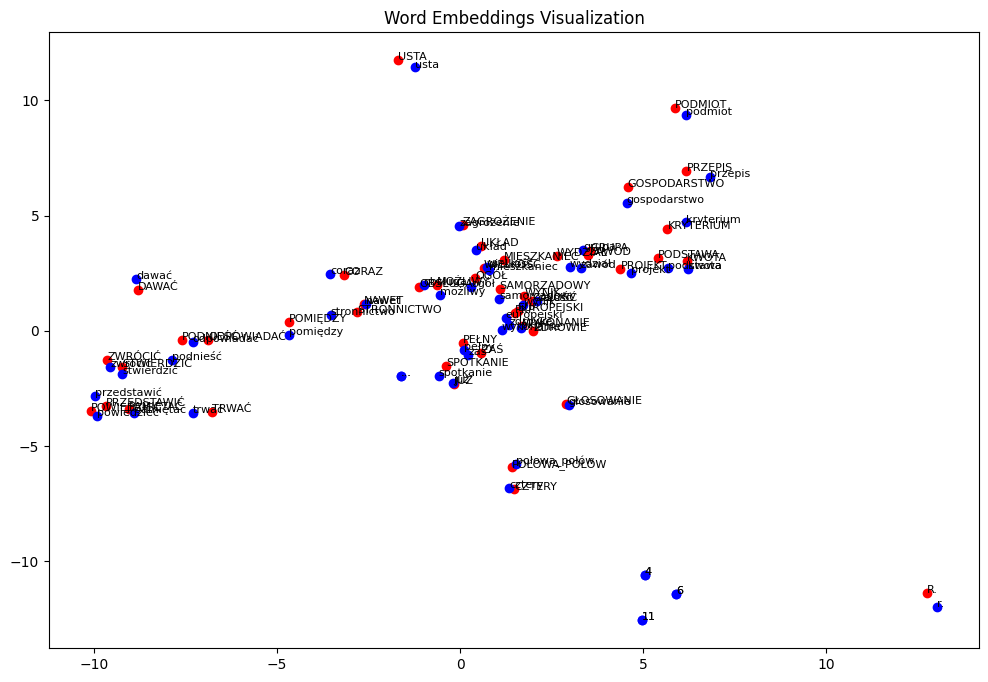

In [74]:
import gensim
import numpy as np
from gensim.models import Word2Vec
from collections import Counter
import random
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load corpora
def load_corpus(path):
    with open(path, 'r', encoding='utf-8') as f:
        return [line.strip().split() for line in f]

upper_sentences = load_corpus('input/task3_polish_upper.txt')
lower_sentences = load_corpus('input/task3_polish_lower.txt')

# Build vocabulary and create translation dictionary
upper_counts = Counter(word for sent in upper_sentences for word in sent)
top_upper = [word for word, _ in upper_counts.most_common(1000)]
D = {word: word.lower() for word in top_upper}
reverse_D = {v: k for k, v in D.items()}

# Generate modified sentences
modified_upper = [[D.get(word, word) for word in sent] for sent in upper_sentences]
modified_lower = [[reverse_D.get(word, word) for word in sent] for sent in lower_sentences]

# Combine all sentences
combined_corpus = upper_sentences + lower_sentences + modified_upper + modified_lower

# Train Word2Vec model
model = Word2Vec(combined_corpus, vector_size=100, window=5, min_count=1, workers=6)
wv = model.wv

# Evaluation functions
def calculate_scores(target_words, wv):
    scores = []
    lower_words = [word for word in wv.key_to_index if word.islower()]
    lower_vectors = wv[lower_words]
    lower_norms = np.linalg.norm(lower_vectors, axis=1)
    
    for word in target_words:
        trans = word.lower()
        if trans not in wv.key_to_index:
            scores.append(0)
            continue
            
        vec = wv[word]
        norm = np.linalg.norm(vec)
        if norm == 0:
            scores.append(0)
            continue
            
        similarities = np.dot(lower_vectors, vec) / (lower_norms * norm)
        sorted_indices = np.argsort(-similarities)
        
        try:
            rank = np.where(sorted_indices == lower_words.index(trans))[0][0] + 1
            scores.append(1/rank)
        except:
            scores.append(0)
    
    return np.mean(scores)

# Calculate scores
d_words = list(D.keys())
non_d_upper = [word for word in wv.key_to_index 
               if word.isupper() and word not in D]
non_d_sample = random.sample(non_d_upper, min(1000, len(non_d_upper)))

score_d = calculate_scores(d_words, wv)
score_non_d = calculate_scores(non_d_sample, wv)

print(f"Average score for D words: {score_d:.4f}")
print(f"Average score for non-D words: {score_non_d:.4f}")

# Visualization
def plot_embeddings(words, translations, wv):
    vectors = []
    labels = []
    for w, t in zip(words, translations):
        if w in wv and t in wv:
            vectors.extend([wv[w], wv[t]])
            labels.extend([w, t])
    
    pca = PCA(n_components=2)
    reduced = pca.fit_transform(vectors)
    
    plt.figure(figsize=(12, 8))
    for i, label in enumerate(labels):
        x, y = reduced[i]
        color = 'red' if label.isupper() else 'blue'
        plt.scatter(x, y, c=color)
        plt.text(x, y, label, fontsize=8)
    
    plt.title('Word Embeddings Visualization')
    plt.show()

sample_words = random.sample(d_words, 50)
sample_trans = [D[w] for w in sample_words]
plot_embeddings(sample_words, sample_trans, wv)